In [ ]:
!pip install -q imbalanced-learn sastrawi tqdm
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import pandas as pd
import numpy as np
df = pd.read_excel('instagram_tpa.xlsx')
df

,comment_id,created_at,profile_pic_url,text,user_id,username,sentimen
0,18106873924547125,1754145030,https://scontent-cgk1-1.cdninstagram.com/v/t51...,@sanggarnadewa_ gaberner nya gak mau nyontoh s...,34472665,riyantoocatur,negatif
1,17856509007473216,1754145109,https://scontent-cgk1-1.cdninstagram.com/v/t51...,@piterpanjaitan hahahaha siap2 buang sampah di...,34472665,riyantoocatur,negatif
2,18073700306061795,1754146230,https://scontent-cgk2-2.cdninstagram.com/v/t51...,Sebentar lagi akan banyak muncul ledakan tikus...,26542587626,prime.nations,negatif
3,18079970224909658,1754146304,https://scontent-cgk2-2.cdninstagram.com/v/t51...,@piterpanjaitan mental feodal. Ntar lama² yg d...,26542587626,prime.nations,negatif
4,18038619920654715,1754146430,https://scontent-cgk2-1.cdninstagram.com/v/t51...,"@krisnadevy sebenarnya udah dari lama kok itu,...",415506737,bagusokasurya,positif
...,...,...,...,...,...,...,...
728,18056485606976141,1736141710,https://scontent-cgk1-2.cdninstagram.com/v/t51...,Lalu wacanakan buka TPA baru??? 🤣🤣🤣 Kalau disa...,2030537794,sucitaia29,negatif
729,18017353373450143,1736143857,https://scontent-cgk2-2.cdninstagram.com/v/t51...,Wacana without solution.. 😢😢 very good goverme...,3134749851,anom21bali_driver,negatif
730,18323325508090747,1736203704,https://scontent-cgk2-2.cdninstagram.com/v/t51...,Masalah tanpa solusi.solusi dengan masalah,144569735,nyomanbudhiarmini,negatif
731,18174377800312367,1736211909,https://scontent-cgk2-2.cdninstagram.com/v/t51...,Tinggal taruh bungkusan di setiap jalan dan ga...,3169890980,igammulyawan,negatif


In [ ]:
df.shape

(733, 7)

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    636
positif     97
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df['text'] = df['text'].apply(clean_text)
df

,comment_id,created_at,profile_pic_url,text,user_id,username,sentimen
0,18106873924547125,1754145030,https://scontent-cgk1-1.cdninstagram.com/v/t51...,gaberner nya gak mau nyontoh surabaya,34472665,riyantoocatur,negatif
1,17856509007473216,1754145109,https://scontent-cgk1-1.cdninstagram.com/v/t51...,hahahaha siap2 buang sampah disungai biar maki...,34472665,riyantoocatur,negatif
2,18073700306061795,1754146230,https://scontent-cgk2-2.cdninstagram.com/v/t51...,sebentar lagi akan banyak muncul ledakan tikus...,26542587626,prime.nations,negatif
3,18079970224909658,1754146304,https://scontent-cgk2-2.cdninstagram.com/v/t51...,mental feodal ntar lama yg disalahin pasti pen...,26542587626,prime.nations,negatif
4,18038619920654715,1754146430,https://scontent-cgk2-1.cdninstagram.com/v/t51...,sebenarnya udah dari lama kok itu cuma dilanju...,415506737,bagusokasurya,positif
...,...,...,...,...,...,...,...
728,18056485606976141,1736141710,https://scontent-cgk1-2.cdninstagram.com/v/t51...,lalu wacanakan buka tpa baru kalau disamping r...,2030537794,sucitaia29,negatif
729,18017353373450143,1736143857,https://scontent-cgk2-2.cdninstagram.com/v/t51...,wacana without solution very good goverment,3134749851,anom21bali_driver,negatif
730,18323325508090747,1736203704,https://scontent-cgk2-2.cdninstagram.com/v/t51...,masalah tanpa solusi solusi dengan masalah,144569735,nyomanbudhiarmini,negatif
731,18174377800312367,1736211909,https://scontent-cgk2-2.cdninstagram.com/v/t51...,tinggal taruh bungkusan di setiap jalan dan ga...,3169890980,igammulyawan,negatif


In [ ]:
df.drop(['comment_id', 'created_at', 'profile_pic_url', 'user_id', 'username' ], axis=1, inplace=True)
df.shape

(733, 2)

In [ ]:
df_norm = df["text"]
df_norm
norm = {
    " tdk " : " tidak ",
    " gaberner " : " gubernur ",
    " gak " : " tidak ",
    " ga " : " tidak ",
    " ngga " : " tidak ",
    " nggak " : " tidak ",
    " tak " : " tidak ",
    " tdk " : " tidak ",
    " tak " : " tidak ",
    " ngak " : " tidak ",
    " enggak " : " tidak" ,
    " ngk " : " tidak ",
    " siap2 " : " siap-siap ",
    " tikus² " : " tikus-tikus ",
    " ntar " : " nanti ",
    " yg " : " yang ",
    " feodal² " : " lemah-lemah ",
    " feodal " : " lemah ",
    " emmm " : " ah ",
    " krna " : " itu ",
    " jga " : " juga ",
    " lgi " : " lagi ",
    " lg " : " lagi ",
    " jga " : " juga ",
    " jg " : " juga ",
    " piodalan " : " upacara ",
    " sampah2 " : " sampah-sampah ",
    " sperti " : " seperti ",
    " sprt " : " seperti ",
    " spt " : " seperti ",
    " sprti " : " seperti ",
    " kija " : " kemana ",
    " kira2 " : " kira-kira ",
    " abe " : " bawa ",
    " dg " : " dengan ",
    " dgn " : " dengan ",
    " dgan " : " dengan ",
    " degn " : " dengan ",
    " selepang " : " masuk ",
    " kykne " : " sepertinya ",
    " selepang " : " masuk ",
    " bakat " : " bakar ",
    " tp " : " tapi ",
    " tpi " : " tapi ",
    " de " : " jangan ",
    " ngendah " : " macam-macam ",
    " ngekoh " : " malas ",
    " tp " : " tapi ",
    " tpi " : " tapi ",
    " past " : " pasti ",
    " liu " : " banyak",
    " d " : " di ",
    " tukade " : " sungai ",
    " samoah " : " sampah ",
    " to " : " itu ",
    " gen " : " saja ",
    " ttp " : " tetap ",
    " ditu " : " disana ",
    " ngentung " : " buang ",
    " krna " : " karena ",
    " be " : " sudah ",
    " orin " : " beritahu ",
    " nak " : " orang ",
    " ngekoh " : " malas ",
    " kel " : " mau ",
    " jani " : " sekarang ",
    " sajab " : " saja ",
    " samapah " : " sampah ",
    " kadena " : " dikira ",
    " mekejang " : " semua ",
    " jelemene " : " manusia ",
    " ngelah " : " punya ",
    " tebe " : " ladang ",
    " anggon " : " pakai ",
    " ngejang " : " taruh ",
    " smapah " : " sampah ",
    " lengeh " : " bodoh ",
    " aturannkadang " : " aturan ",
    " yg " : " yang ",
    " lebian " : " berlebihan ",
    " ngenem " : " minum ",
    " arah " : " alkohol ",
    " lengehhhhh " : " bodoh ",
    " smapah " : " sampah ",
    " smpah " : " sampah ",
    " smapahnya " : " sampah ",
    " booommm " : " bom ",
    " emamg " : " emang ",
    " but " : " buat ",
    " abe " : " bawa ",
    " pang " : " supaya ",
    " ade " : " ada ",
    " angetin " : " ingat ",
    " kelazz " : " keren ",
    " dg " : " dengan ",
    " dgn " : " dengan ",
    " kleng " : " dasar ",
    " samoah " : " sampah ",
    " jln " : " jalan ",
    " gn " : " gunung ",
    " sblm " : " sebelum ",
    " ad " : " ada ",
    " duid " : " uang ",
    " kntor " : " kantor ",
    " gada " : " tidak ada ",
    " jd " : " jadi ",
    " pete " : " omong ",
    " gen " : " saja ",
    " sing " : " tidak ",
    " mungki " : " mungkin ",
    " sperti " : " seperti ",
    " ane " : " yang ",
    " kije " : " kemana ",
    " dije " : " dimana ",
    " tongos " : " tempat ",
    " ne " : " ini ",
    " bgt " : " sekali ",
    " iyaa " : " ya ",
    " jelasss " : " jelas ",
    " bangettt " : " sekali ",
    " kmana " : " kemana ",
    " tyg " : " saya ",
    " mndukung " : " mendukung ",
    " klo " : " kalau ",
    " jdi " : " jadi ",
    " jalan2 " : " jalan-jalan ",
    " dll " : " lainnya ",
    " sy " : " saya ",
    " apkah " : " apakah ",
    " otw " : " berangkat ",
    " kosan " : " kos ",
    " nu " : " masih ",
    " bpk " : " bapak ",
    " dtg " : " datang ",
    " ad " : " ada ",
    " cm " : " cuma ",
    " trus " : " terus ",
    " gmn " : " gimana ",
    " aplgi " : " apalagi ",
    " org " : " orang ",
    " sebwlum " : " sebelum ",
    " cariakn " : " carikan ",
    " smdiri " : " sendiri ",
    " inguh " : " stres ",
    " ben " : " akibat ",
    " ayooooo " : " ayo ",
    " bagusndulu " : " bagus ",
    " duitnya " : " uangnya ",
    " smpe " : " sampai ",
    " rame2 " : " ramai-ramai ",
    " samph " : " sampah ",
    " tamba " : " tambah ",
    " ruwet " : " susah ",
    " skrng " : " sekarang ",
    " yen " : " kalau ",
    " ketoamg " : " begitu ",
    " payu " : " jadi ",
    " delod " : " selatan ",
    " meadep " : " hadap ",
    " udh " : " sudah ",
    " rmh " : " rumah ",
    " utk " : " untuk ",
    " cri " : " cari ",
    " byk " : " banyak ",
    " kalo " : " kalau ",
    " bisaaa " : " bisa ",
    " cuan " : " uang ",
    " sepwrti " : " seperti ",
    " sudah2 " : " sudah-sudah ",
    " lama2 " : " lama-lama ",
    " awikwok " : " lucu ",
    " drmh " : " dirumah ",
    " sungaii " : " sungai ",
    " sirng " : " sering ",
    " paaaaakkkk " : " pak ",
    " adecchhhh " : " aduh ",
    " bnyak " : " banyak ",
    " sendri " : " sendiri ",
    " menrutku " : " menurutku ",
    " blum " : " belum ",
    " bner2 " : " bener-bener ",
    " tpi " : " tapi ",
    " solusii " : " solusi ",
    " sekdar " : " sekedar ",
    " dittup " : " ditutup ",
    " bgini " : " begini ",
    " masyarakatpun " : " masyarakat ",
    " sekala " : " skala ",
    " klo " : " kalau ",
    " aza " : " saja ",
    " dr " : " dari ",
    " gimn " : " gimana ",
    " penholahan " : " pengolahan ",
    " munhkin " : " mungkin ",
    " perlunua " : " perlunya ",
    " pantet " : " pantas ",
    " nak " : " anak ",
    " orin " : " suruh ",
    " ngae " : " buat ",
    " urug " : " timbun ",
    " cg " : " saya ",
    " umah " : " rumah ",
    " ci " : " kamu ",
    " ji " : " dengan ",
    " luu " : " sampah ",
    " nyen " : " nanti ",
    " ulah " : " sembarangan ",
    " aluh " : " mudah ",
    " kuang " : " kurang ",
    " liunan " : " kebanyakan ",
    " kenape " : " kenapa ",
    " jak " : " dengan ",
    " pedidi " : " sendiri ",
    " nah " : " ya ",
    " masing2 " : " masing-masing ",
    " semeton " : " masyarakat ",
    " niki " : " ini ",
    " ujung2nya " : " ujung-ujungnya ",
    " lbh " : " lebih ",
    " dipake " : " pakai ",
    " ama " : " dengan ",
    " gada " : " tidak ada ",
    " nganggo " : " pakai ",
    " ngelola " : " kelola ",
    " kalo " : " kalau ",
    " jgn " : " jangan ",
    " suapii " : " keren ",
    " wii " : " kakak ",
    " buanyak " : " banyak ",
    " ntar " : " nanti ",
    " japri " : " kabar ",
    " rame2 " : " rame-rame ",
    " mmembuat " : " membuat ",
    " ulian " : " karena ",
    " drumah " : " dirumah ",
    " biaa " : " bisa ",
    " abing " : " jurang ",
    " tdk " : " tidak ",
    " goblok " : " bodoh ",
    " goovernoor " : " gubernur ",
    " napa " : " kenapa ",
    " donk " : " dong ",
    " sndiri " : " sendiri ",
    " bli " : " kakak ",
    " kmn " : " kemana ",
    " meghasilkan " : " menghasilkan ",
    " masyarkat " : " masyarakat ",
    " sbelum " : " sebelum ",
    " rahayu " : " damai ",
    " yg " : " yang ",
    " semeton " : " saudara ",
    " kelolah " : " kelola ",
    " aj " : " saja ",
    " samph " : " sampah ",
    " emng " : " memang ",
    " dsna " : " disana ",
    " ia " : " ya ",
    " kura2 " : " kura-kura ",
    " perum " : " perumahan ",
    " kyknya " : " sepertinya ",
    " yen " : " kalau ",
    " saje " : " benar ",
    " siap2 " : " siap-siap ",
    " ase " : " sepertinya ",
    " dimana2 " : " dimana-mana ",
    " lalah " : " lelah",
    " jani " : " sekarang ",
    " dirumah2 " : " dirumah-rumah ",
    " kantor2 " : " kantor-kantor ",
    " dr " : " dari ",
    " gmn " : " gimana ",
    " diijinkan " : " diizinkan ",
    " natah " : " halaman ",
    " cupit " : " sempit ",
    " banyam " : " banyak ",
    " suksma " : " terimakasih ",
    " smoky " : " asap ",
    " kyk " : " seperti ",
    " dsni " : " disini ",
    " udh " : " sudah ",
    " pke " : " pakai ",
    " bgni " : " begini ",
    " utam " : " utama ",
    " dec " : " desember ",
    " kije " : " kemana ",
    " laku " : " alur ",
    " sich " : " sih ",
    " ktika " : " ketika ",
    " kacung2 " : " pesuruh ",
    " cma " : " hanya ",
    " bbrp " : " beberapa ",
    " skrg " : " sekarang ",
    " kalo " : " kalau ",
    " gaboleh " : " dilarang ",
    " tyang " : " saya ",
    " sajaan " : " sekali ",
    " nawang " : " tahu ",
    " ije " : " dimana ",
    " ngalih " : " cari ",
    " ngutang " : " buang ",
    " sampah2 " : " sampah-sampah ",
    " tamu2 " : " tamu-tamu ",
    " pedalem " : " kasihan ",
    " umah" : " rumah ",
    " kaden " : " dikira ",
    " mayah " : " bayar ",
    " aluh " : " gampang ",
    " ngae " : " buat ",
    " rage " : " kita ",
    " maan " : " dapat ",
    " kuangan " : " kurang ",
    " tongos " : " tempat ",
    " adep " : " jual ",
    " ulian " : " karena ",
    " lung " : " patah ",
    " jgn " : " jangan ",
    " tmpat " : " tempat ",
    " weee " : " hei ",
    " paaaaaaakkkkkkk " : " pak ",
    " trs " : " terus ",
    " herannn " : " heran",
    " masy " : " masyarakat ",
    " ngluarin " : " keluar ",
    " duit " : " uang ",
    " mrela " : " mereka ",
    " gasadar " : " tidak sadar ",
    " wong " : " malah ",
    " mlh " : " malah ",
    " mslh " : " masalah ",
    " kelar2 " : " selesai-selesai ",
    " med " : " bosan ",
    " deeh " : " saja ",
    " bpke " : " bapak ",
    " nto " : " itu ",
    " mimih " : " miris ",
    " dridulu " : " dari dulu ",
    " ktny " : " katanya ",
    " mw " : " mau ",
    " tutup2 " : " tutup-tutup ",
    " tmptny " : " tempatnya ",
    " uda " : " sudah ",
    " kpd " : " kepada ",
    " drpd " : " daripada ",
    " tok " : " untuk ",
    " oenutuoan " : " penutupan ",
    " bs " : " bisa ",
    " tp " : " tapi ",
    " kliab " : " niat ",
    " pang " : " supaya ",
    " ngamah " : " makan ",
    " ken " : " dengan ",
    " metajen " : " sabung ayam ",
    " gen " : " saja ",
    " ye " : " dia ",
    " ngae " : " buat ",
    " suud " : " selesai ",
    " to " : " itu ",
    " masyarkat " : " masyarakat ",
    " meragatang " : " selesaikan ",
    " buin " : " lagi ",
    " jeg " : " aduh ",
    " keliabne " : " niat ",
    " gubenur " : " gubernur ",
    " tgl " : " tanggal ",
    " uda " : " sudah ",
    " kresek2 " : " kresek-kresek ",
    " jln " : " jalan ",
    " mayah " : " bayar ",
    " meangkut " : " diangkut ",
    " kanti " : " sampai ",
    " jlek " : " jelek ",
    " bone " : " baunya ",
    " liat " : " lihat ",
    " baru2 " : " baru-baru ",
    " rumah2 " : " rumah-rumah ",
    " tiba2 " : " tiba-tiba ",
    " mall2 " : " mall-mall",
    " ramai2 " : " ramai-ramai ",
    " dirmh " : " dirumah ",
    " milah2 " : " milah-milah ",
    " pocol " : " rugi ",
    " banget " : " sekali ",
    " nnti " : " nanti ",
    " mmng " : " memang ",
    " sllu " : " selalu ",
    " sering2 " : " sering-sering ",
    " engken " : " gimana ",
    " dsnalah " : " disana ",
    " ampura " : " maaf ",
    " yening " : " kalau ",
    " iwan " : " salah ",
    " gakbener " : " gubernur ",
    " toh " : " jugaan ",
    " inj " : " ini ",
    " nyen " : " siapa ",
    " anu " : " yang ",
    " gt " : " gitu ",
    " ntr " : " nanti ",
    " pd " : " pada ",
    " dg " : " dengan ",
    " gurbenur " : " gubernur",
    " hr " : " hari ",
    " bearti " : " berarti ",
    " jgn " : " jangan ",
    " timbulan " : " timbunan ",
    " punys " : " punya ",
    " dsbnya " : " dan sebagainya",
    " rumjab " : " rumah ",
    " kyk " : " kayak ",
    " waoooww " : " wow ",
    " emejing " : " amazing ",
    " tukad " : " sungai ",
    " lebian " : " berlebihan ",
    " kaden " : " dikira ",
    " piss " : " uang ",
    " kewehh " : " sulit ",
    " ngalih " : " cari ",
    " jani " : " sekarang ",
    " ket " : " sampai ",
    " ngutang " : " buang ",
    " lulu " : " sampah ",
    " kewehhh " : " sulit ",
    " trs " : " terus ",
    " apang " : " supaya ",
    " kene " : " kena ",
    " nyen " : " siapa ",
    " keneh " : " perasaan ",
    " dadine " : " jadinya ",
    " tampa " : " tanpa ",
    " sampe " : " sampai ",
    " dioergunakan " : " dipergunakan ",
    " aruuuh " : " aduh ",
    " ada2 " : " ada-ada ",
    " laaah " : " lah ",
    " pny " : " punya ",
    " jebreeeet " : " tiba-tiba ",
    " ngemang " : " memberi ",
    " ato " : " itu ",
    " gaenin " : " buatkan ",
    " tongos " : " tempat ",
    " mare " : " baru ",
    " mebading " : " terbalik ",
    " mule " : " memang ",
    " sinkgard " : " sehingga ",
    " msh " : " masih ",
    " cuan " : " uang ",
    " budgetnya " : " uangnya ",
    " bgt " : " sekali ",
    " drpd " : " daripada ",
    " duit " : " uang ",
    " iraga " : " kita ",
    " nuutin " : " nurut ",
    " pipis " : " uang ",
    " ci " : " anda ",
    " gen " : " saja ",
    " be " : " sudah ",
    " rmh " : " rumah ",
    " dpn " : " depan ",
    " de " : " jangan ",
    " ngorain " : " perintah ",
    " doen " : " saja ",
    " ddi " : " jadi ",
    " baang " : " beri ",
    " maseh " : " juga ",
    " nh " : " ya ",
    " ank " : " anak ",
    " nglh " : " punya ",
    " umh " : " rumah ",
    " ije " : " dimana ",
    " kal " : " akan ",
    " ngae " : " buat ",
    " lobanggg " : " lubang ",
    " capek2 " : " lelah ",
    " kali " : " sekali ",
    " cow " : " laki-laki ",
    " gag " : " tidak ",
    " ditrima " : " terima ",
    " alihan " : " pekerjaan ",
    " keweh " : " sulit ",
    " mis " : " sampah ",
    " dondonan " : " dedaunan ",
    " menkije " : " kemana ",
    " kutang " : " buang ",
    " baang " : " berikan ",
    " jani " : " sekarang ",
    " bakat " : " malah ",
    " urug " : " timbun ",
    " aji " : " dengan ",
    " dlu " : " dulu ",
    " dipinggir2 " : " dipinggir-pinggir ",
    " anggo " : " pakai ",
    " otake " : " otak ",
    " lengeh " : " bodoh ",
    " karna " : " karena ",
    " ade " : " ada ",
    " siap2 " : " siap-siap ",
    " pinggir2 " : " pinggir-pinggir ",
    " massive " : " masif ",
    " skalian " : " sekalian ",
    " nike " : " itu ",
    " dps " : " denpasar ",
    " kadang2 " : " kadang-kadang ",
    " kanggo " : " terserah ",
    " je " : " saja ",
    " pk " : " pakai ",
    " th " : " tahun ",
    " yt " : " youtube ",
    " gmna " : " gimana ",
    " dibungkus2 " : " dibungkus-bungkus ",
    " kecil2 " : " kecil-kecil ",
    " aja " : " saja ",
    " lama2" : " lama-lama ",
    " pelan2 " : " pelan-pelan ",
    " kotak2 " : " kotak-kotak ",
    " mudah2an " : " mudah-mudahan ",
    " adh " : " sudah ",
    " piyeeeee " : " gimana ",
    " cba " : " coba ",
    " mnghadapi " : " menghadapi ",
    " bauk " : " bau ",
    " klu " : " kalau ",
    " g " : " tidak ",
    " tebe " : " lahan ",
    " kk " : " keluarga ",
    " yok " : " ayo ",
    " sbenernya " : " sebenarnya ",
    " taggung " : " tanggung ",
    " dmulai " : " dimulai ",
    " kluarga " : " keluarga ",
    " spt " : " seperti ",
    " brapapun " : " berapa pun",
    " penanmpungan " : " penampungan ",
    " sberapapun " : " seberapa pun ",
    " ttp " : " tetap ",
    " masyrakat " : " masyarakat ",
    " sm " : " sama ",
    " kel " : " akan ",
    " gede " : " besar ",
    " begad " : " sapi",
    " jalan² " : " jalan-jalan ",
    " dr " : " dari ",
    " malll " : " mall ",
    " eja " : " saja ",
    " salpah " : " sampah ",
    " karang " : " sekarang ",
    " sj " : " saja ",
    " hrus " : " harus ",
    " puny " : " punya ",
    " melara " : " melarang ",
    " hrs " : " harus ",
    " maboye " : " merugi ",
    " aluh " : " mudah ",
    " san " : " sekali ",
    " tdk " : " tidak ",
    " sdh " : " sudah ",
    " thn " : " tahun ",
    " kmren " : " kemarin ",
    " dgr " : " dengar ",
    " baepas " : " bypass ",
    " gg " : " tidak ",
    " smpahnya " : " sampahnya ",
    " smas " : " sama ",
    " solusiiii " : " solusi ",
    " parahhhh " : " parah ",
    " tsb " : " tersebut ",
    " dimana2 " : " dimana-mana ",
    " aneh2 " : " aneh-aneh ",
    " kek " : " seperti ",
    " pdhal " : " padahal ",
    " org² " : " orang-orang ",
    " lahan² " : " lahan-lahan ",
    " tikus² " : " tikus-tikus ",
    " lalat² " : " lalat-lalat ",
    " pang " : " agar ",
    " ngerase " : " terasa ",
    " main2 " : " main-main ",
    " emg " : " memang ",
    " cmn " : " hanya ",
    " bpk " : " bapak ",
    " krena " : " karena ",
    " masalah2 " : " masalah-masalah ",
    " pekab4t " : " pejabat ",
    " tiba2 " : " tiba-tiba ",
    " ndak " : " tidak ",
    " yukkk " : " ayo ",
    " masyarakan " : " masyarakat ",
    " kura - kura " : " kira-kira ",
    " bangett " : " sekali ",
    " masak " : " benarkah ",
    " anggo " : " pakai ",
    " baang " : " biarkan ",
    " mare " : " baru ",
    " pang " : " agar ",
    " maan " : " dapat ",
    " ulian " : " sebab ",
    " aluh " : " mudah ",
    " gati " : " sekali ",
    " care " : " seperti ",
    " pesu " : " keluar ",
    " uling " : " dari ",
    " song " : " lubang ",
    " gau " : " tau ",
    " ajah " : " saja ",
    " orng " : " orang ",
    " lama2 " : " lama-lama ",
    " tersilit " : " tersulit ",
    " smntara " : " sementara ",
    " lap " : " lapangan ",
    " pk " : " pak ",
    " kirbankan " : " korbankan ",
    " gaberner " : " gubernur ",
    " seruju " : " setuju ",
    " da " : " di ",
    " taen " : " pernah ",
    " duwur " : " atas ",
    " ulian " : " karena ",
    " alihang " : " carikan ",
    " satt " : " dasar ",
    " hrs " : " harus ",
    " bgaimana " : " bagaimana ",
    " dinegri " : " di negeri ",
    " meli " : " beli ",
    " kudang " : " berapa ",
    " kene " : " begini ",
    " sugih " : " kaya ",
    " teruskunjungan " : " terus kunjungan ",
    " dogen " : " saja ",
    " mragatang " : " selesaikan ",
    " oowww " : " oh ",
    " alihange " : " carikan ",
    " len"  : " lain ",
    " kije " : " dimana ",
    " sekali2 " : " sekali-sekali ",
    " ta " : " tidak ",
    " ujug2 " : " tiba-tiba ",
    " gelem " : " sakit ",
    " gungggg " : " pak ",
    " yng " : " yang ",
    " getih " : " darah ",
    " sube " : " sudah ",
    " kadung " : " terlanjur ",
    " barak " : " merah ",
    " liunan " : " kebanyakan ",
    " jleme " : " manusia ",
    " suksma " : " terimakasih ",
    " kone " : " katanya ",
    " kal " : " akan ",
    " kaden " : " dikira ",
    " nak " : " orang ",
    " jik " : " pak ",
    " tyg " : " saya ",
    " gen " : " saja ",
    " nggih " : " ya ",
    " wi " : " kakak ",
    " be " : " sudah ",
    " ngangguang " : " syukuri ",
    " jani " : " sekarang ",
    " lu " : " dulu ",
    " nyen " : " siapa ",
    " tgl " : " tanggal ",
    " mekejang " : " semua ",
    " mesebeng " : " paras ",
    " uli " : " dari ",
    " kanti " : " sampai ",
    " pragat " : " selesai ",
    " lamun " : " namun ",
    " sube " : " sudah ",
    " dueg " : " pintar ",
    " bule2 " : " bule-bule ",
    " asan " : " rasanya ",
    " pengolhan " : " pengolahan ",
    " nyak " : " mau ",
    " keto " : " begitu ",
    " puaaaak " : " pak ",
    " gaenan " : " buatkan ",
    " sik " : " di ",
    " pemimpine " : " pemimpinnya ",
    " pang " : " agar ",
    " yo " : " dia ",
    " ditu" : " disana ",
    " ngalih " : " cari ",
    " jin " : " isi ",
    " dik " : " sedikit ",
    " dijarkan " : " dijabarkan ",
    " ngidang " : " bisa ",
    " meli " : " beli ",
    " sampun " : " sudah ",
    " de " : " jangan ",
    " ane " : " yang ",
    " belog " : " bodoh ",
    " be " : " sudah ",
    " kadong " : " terlanjur ",
    " nden " : " sebentar ",
    " malu " : " dulu ",
    " nu " : " masih ",
    " sesai " : " sering ",
    " mlali " : " jalan-jalan ",
    " anak " : " orang ",
    " melali " : " jalan-jalan ",
    " deen " : " saja ",
    " idup " : " hidup ",
    " ente " : " itu ",
    " bneh " : " benar ",
    " san " : " sekali ",
    " sajan " : " benar ",
    " ape " : " apa ",
    " sg " : " tidak ",
    " ade " : " ada ",
    " d " : " pak ",
    " rage " : " kita ",
    " jang " : " taruh ",
    " tawange " : " diketahui ",
    " ajak " : " oleh ",
    " upp " : " mantap ",
    " besyukur " : " bersyukur ",
    " orang2 " : " orang-orang ",
    " kaleng2 " : " sembarangan ",
    " sayannya " : " sayangnya ",
    " oknum2 " : " oknum-oknum ",
    " bangke " : " mati ",
    " bise " : " bisa ",
    " gubernut " : " gubernur ",
    " dadine " : " jadinya ",
    " konden " : " belum ",
    " tampliiiig " : " pukul ",
    " dbawa " : " dibawa ",
    " kkntor " : " ke kantor ",
    " gubern*r " : " gubernur ",
    " mula " : " memang ",
    " ngae " : " buat ",
    " ping " : " agar ",
    " kapah " : " jarang ",
    " jemak " : " ambil ",
    " penjahbatnya " : " pejabatnya ",
    " pidan " : " dahulu ",
    " tileh " : " masih ",
    " gen " : " saja ",
    " suud2 " : " selesai-selesai ",
    " goer2 " : " koar-koar ",
    " sud " : " setelah ",
    " bongolll " : " tuli ",
    " sanduk " : " seruduk ",
    " tiang " : " saya ",
    " barus " : " harus ",
    " emote " : " emotikon ",
    " kedek " : " tertawa ",
    " cing " : " dasar ",
    " kanti " : " sampai ",
    " kampil " : " karung ",
    " umah " : " rumah ",
    " cang " : " saya ",
    " mepete " : " bicara ",
    " orin " : " suruh ",
    " nyemak " : " ambil ",
    " kene " : " gini ",
    " prejani " : " cepat ",
    " ajak " : " dan ",
    " bongol " : " tuli ",
    " mesing " : " mesin ",
    " len " : " lain ",
    " beline " : " dibeli ",
    " cabk " : " coba ",
    " bakl " : " bakal ",
    " afa " : " ada ",
    " passti " : " pasti ",
    " moderen " : " modern ",
    " pnting " : " penting ",
    " ibah " : " hibah ",
    " ngitungin " : " urusi ",
    " yen " : " kalau ",
    " sube " : " sudah ",
    " je " : " jangankan ",
    " ngendus " : " mencium ",
    " uli " : " dari ",
    " nolih " : " malihat ",
    " pantess " : " pantas ",
    " kanti " : " sampai ",
    " meuled " : " berulat ",
    " jumah " : " dirumah ",
    " seng " : " tidak ",
    " nyemak " : " ambil ",
    " nike " : " itu ",
    " mawinan " : " penyebab ",
    " tiang " : " saya ",
    " hrsnya " : " harusnya ",
    " pejabat2 " : " pejabat-pejabat ",
    " linggah " : " luas ",
    " sugih " : " kaya ",
    " meliah " : " lebih ",
    " agetne " : " untungnya ",
    " konden " : " belum ",
    " pelihange " : " disalahkan ",
    " jak " : " dengan ",
    " bani" : " berani ",
    " prem#n " : " preman ",
    " nyage " : " jaga ",
    " blg " : " bilang ",
    " aget " : " untung ",
    " video2 " : " video-video ",
    " ngidang " : " bisa ",
    " kerennn " : " mantap ",
    " isin " : " isi ",
    " lan " : " ayo ",
    " lu " : " dulu ",
    " dik " : " sedikit ",
    " benyah " : " rusak ",
    " latig " : " parah ",
    " pang " : " biar ",
    " ditu " : " disana ",
    " mepunduh " : " terkumpul ",
    " ngae " : " membuat ",
    " mulene " : " memang ",
    " keto " : " begitu ",
    " mslh " : " masalah ",
    " pragat2 " : " selesai2 ",
    " skonden " : " sebelum ",
    " mare " : " baru ",
    " tiba2 " : " tiba-tiba ",
    " ling " : " sejak ",
    " kude " : " berapa ",
    " adi " : " kenapa ",
    " ugan " : " ketika ",
    " punyya " : " punya ",
    " seendiri " : " sendiri ",
    " ajum " : " sombong ",
    " cenik " : " kecil ",
    " gae " : " kerjaan ",
    " tengilin " : " diamkan ",
    " benyah " : " rusak ",
    " koh " : " malas ",
    " mentingang " : " mementingkan ",
    " dewek " : " diri ",
    " pedidi " : " sendiri ",
    " gen " : " saja ",
    " sane " : " yang ",
    " pelung " : " biru ",
    " ja " : " saja ",
    " kbnyakan " : " kebanyakan ",
    " ipidan " : " dahulu ",
    " rata2 " : " rata-rata ",
    " irage " : " kita ",
    " leluu " : " sampah ",
    " tunjel " : " bakar ",
    " ngangsang " : " semakin ",
    " bedik " : " sedikit ",
    " kutang " : " buang ",
    " pelih " : " salah ",
    " sane " : " yang ",
    " sampun " : " sudah ",
    " ujan2 " : " hujan-hujan ",
    " apa2 " : " apa-apa ",
    " menek " : " naik ",
    " tertahra " : " tentram ",
    " puakk " : " pak ",
    " nyugihang " : " memperkaya ",
    " ibe " : " diri ",
    " pedidi " : " sendiri ",
    " kompotem " : " kompeten ",
    " antyang " : " tunggu ",
    " mlu " : " dulu ",
    " mekalukan " : " berantakan ",
    " dkt " : " dekat ",
    " konyang " : " semua ",
    " tolih " : " lihat ",
    " nakonin " : " bertanya ",
    " sng " : " tidak ",
    " bapak2 " : " bapak-bapak ",
    " nglola " : " kelola ",
    " numpuk2 " : " numpuk-numpuk ",
    " kutang " : " ditinggal ",
    " nyak " : " ayo ",
    " bolehv " : " boleh ",
    " blom " : " belum ",
    " dn " : " dan ",
    " skrng " : " sekarang ",
    " sampah2nya " : " sampah-sampahnya ",
    " gpp " : " tidak apa ",
    " yanga " : " yang ",
    " arruhhhh " : " aduh ",
}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["text"] = df["text"].apply(normalisasi)
df

,text,sentimen
0,gaberner nya tidak mau nyontoh surabaya,negatif
1,hahahaha siap-siap buang sampah disungai biar ...,negatif
2,sebentar lagi akan banyak muncul ledakan tikus...,negatif
3,mental lemah nanti lama yang disalahin pasti p...,negatif
4,sebenarnya udah dari lama kok itu cuma dilanju...,positif
...,...,...
728,lalu wacanakan buka tpa baru kalau disamping r...,negatif
729,wacana without solution very good goverment,negatif
730,masalah tanpa solusi solusi dengan masalah,negatif
731,tinggal taruh bungkusan di setiap jalan dan ga...,negatif


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stop_remover = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stop_remover.remove(text)

df["text"] = df["text"].apply(remove_stopwords)

In [ ]:
tokenized = df["text"].apply(lambda x: x.split())
tokenized

,text
0,"[gaberner, nya, mau, nyontoh, surabaya]"
1,"[hahahaha, siap-siap, buang, sampah, disungai,..."
2,"[sebentar, akan, banyak, muncul, ledakan, tiku..."
3,"[mental, lemah, lama, disalahin, pendatang, ba..."
4,"[sebenarnya, udah, lama, kok, cuma, dilanjutkan]"
...,...
728,"[lalu, wacanakan, buka, tpa, baru, kalau, disa..."
729,"[wacana, without, solution, very, good, goverm..."
730,"[masalah, solusi, solusi, masalah]"
731,"[tinggal, taruh, bungkusan, setiap, jalan, gan..."


In [ ]:
!pip install sastrawi tqdm
import pandas as pd
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tqdm.notebook import tqdm
tqdm.pandas()

stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df["text"] = df["text"].progress_apply(stemming)
df

  0%|          | 0/733 [00:00<?, ?it/s]

,text,sentimen
0,gaberner nya mau nyontoh surabaya,negatif
1,hahahaha siap buang sampah sungai biar makin b...,negatif
2,sebentar akan banyak muncul ledak tikus kota d...,negatif
3,mental lemah lama disalahin datang banyak kerj...,negatif
4,benar udah lama kok cuma lanjut,positif
...,...,...
728,lalu wacana buka tpa baru kalau samping rumah ...,negatif
729,wacana without solution very good goverment,negatif
730,masalah solusi solusi masalah,negatif
731,tinggal taruh bungkus tiap jalan gang di lewat...,negatif


In [ ]:
df = df.dropna(subset=['sentimen'])
df = df[df['text'].str.strip() != '']
teks_komentar = df[['text', 'sentimen']]

In [ ]:
df.to_excel("hasil_stemmingTPA.xlsx", index=False)

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
negatif    634
positif     97
Name: count, dtype: int64


In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['text'])
y = df['sentimen']
print(X_tfidf.shape[1])

1962


In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_tfidf, y)
y_res.value_counts()

,count
sentimen,
negatif,634
positif,634


In [ ]:
# Split dataset dari hasil SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

In [ ]:
# Train MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

Akurasi Training: 0.97
Akurasi Testing: 0.91

=== Classification Report (TRAINING) ===
              precision    recall  f1-score   support

     negatif       0.99      0.94      0.97       507
     positif       0.95      0.99      0.97       507

    accuracy                           0.97      1014
   macro avg       0.97      0.97      0.97      1014
weighted avg       0.97      0.97      0.97      1014


=== Classification Report (TESTING) ===
              precision    recall  f1-score   support

     negatif       0.96      0.86      0.90       127
     positif       0.87      0.96      0.91       127

    accuracy                           0.91       254
   macro avg       0.91      0.91      0.91       254
weighted avg       0.91      0.91      0.91       254



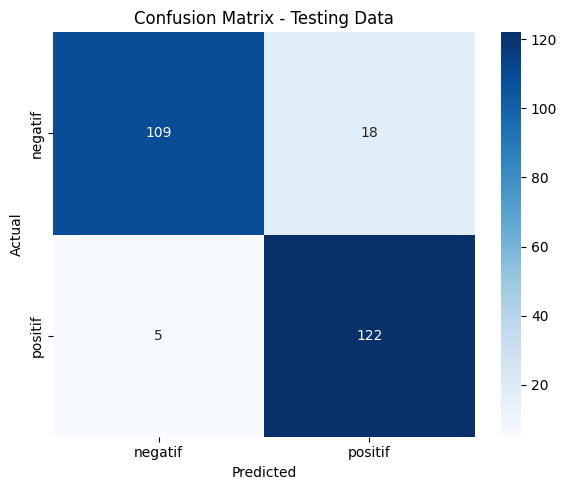

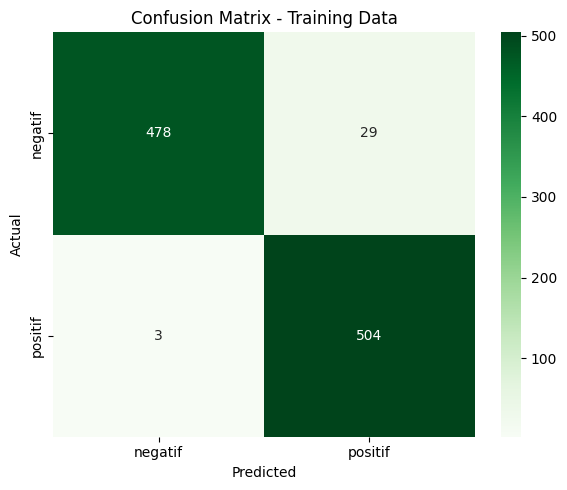

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediksi
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

# Akurasi
akurasi_train = accuracy_score(y_train, y_train_pred)
akurasi_test = accuracy_score(y_test, y_test_pred)

print(f"Akurasi Training: {akurasi_train:.2f}")
print(f"Akurasi Testing: {akurasi_test:.2f}")

# Label kelas
labels = sorted(list(set(y_train) | set(y_test)))

# Classification Report
print("\n=== Classification Report (TRAINING) ===")
print(classification_report(y_train, y_train_pred, target_names=labels))

print("\n=== Classification Report (TESTING) ===")
print(classification_report(y_test, y_test_pred, target_names=labels))

# Confusion Matrix - Testing
cm_test = confusion_matrix(y_test, y_test_pred, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Testing Data')
plt.tight_layout()
plt.show()

# Confusion Matrix - Training
cm_train = confusion_matrix(y_train, y_train_pred, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train.sum(axis=0).A1

top_words_df = pd.DataFrame({
    'Kata': feature_names,
    'Skor_TFIDF': tfidf_sum
}).sort_values(by='Skor_TFIDF', ascending=False)

print(top_words_df.head(20))

            Kata  Skor_TFIDF
1533      sampah   69.788592
1663      solusi   35.038548
1270     organik   24.264276
303         buat   23.185582
694         jadi   23.057188
1505       rumah   20.980473
267         bisa   20.082279
302        buang   18.721193
761        kalau   18.633495
163          bal   17.954838
1349    perintah   17.639479
1043  masyarakat   17.618318
1794       tidak   17.202851
701        jalan   16.811001
1342     penting   15.796892
424           di   15.696114
152        bagus   15.562355
157         baik   15.551931
1371       pilah   15.305919
1390     plastik   15.234417


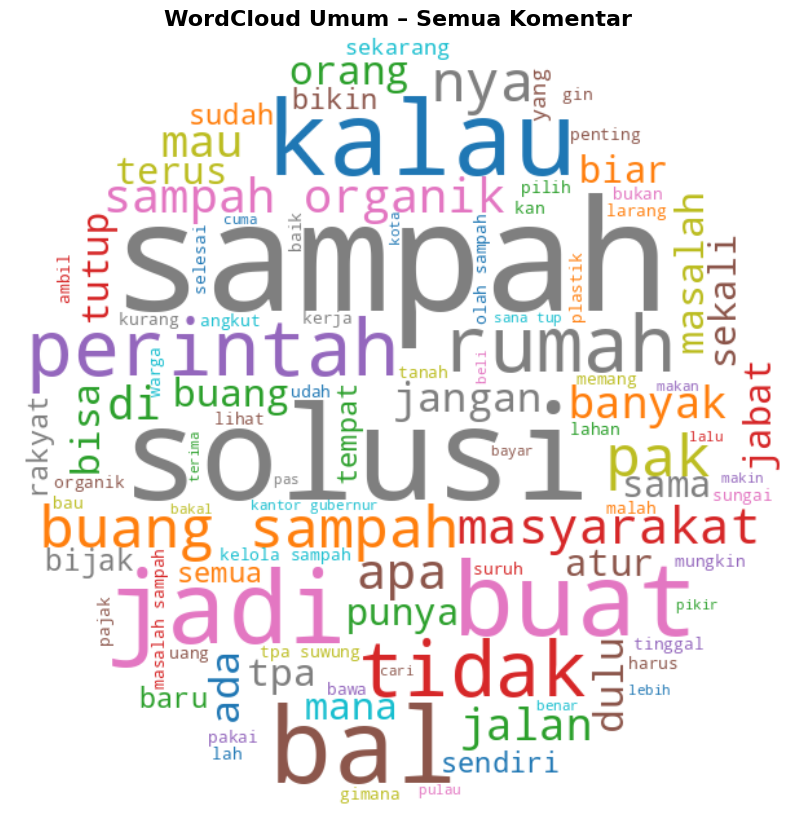

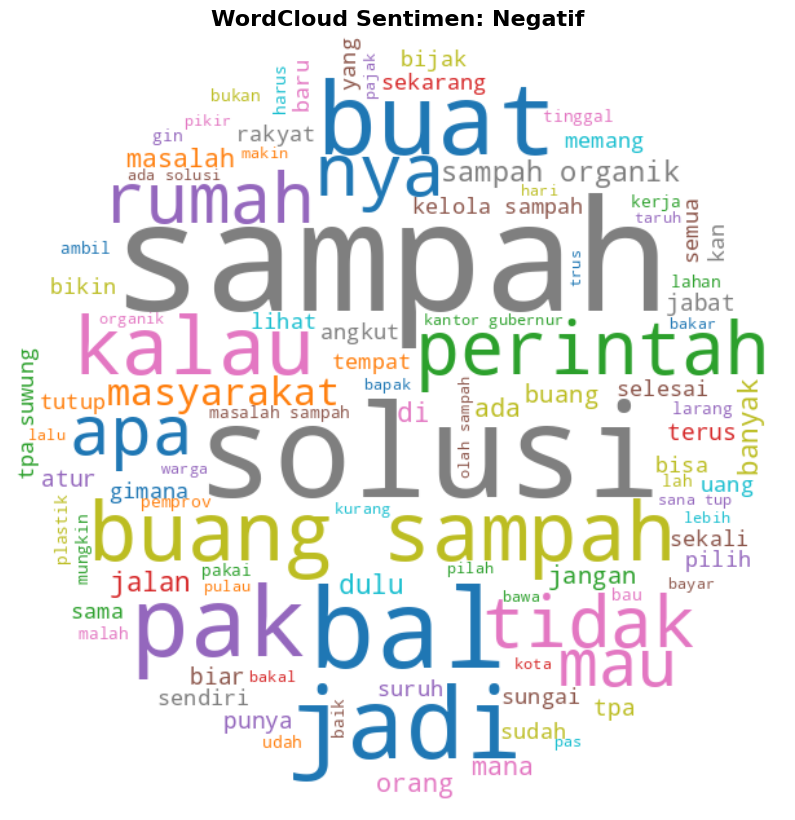

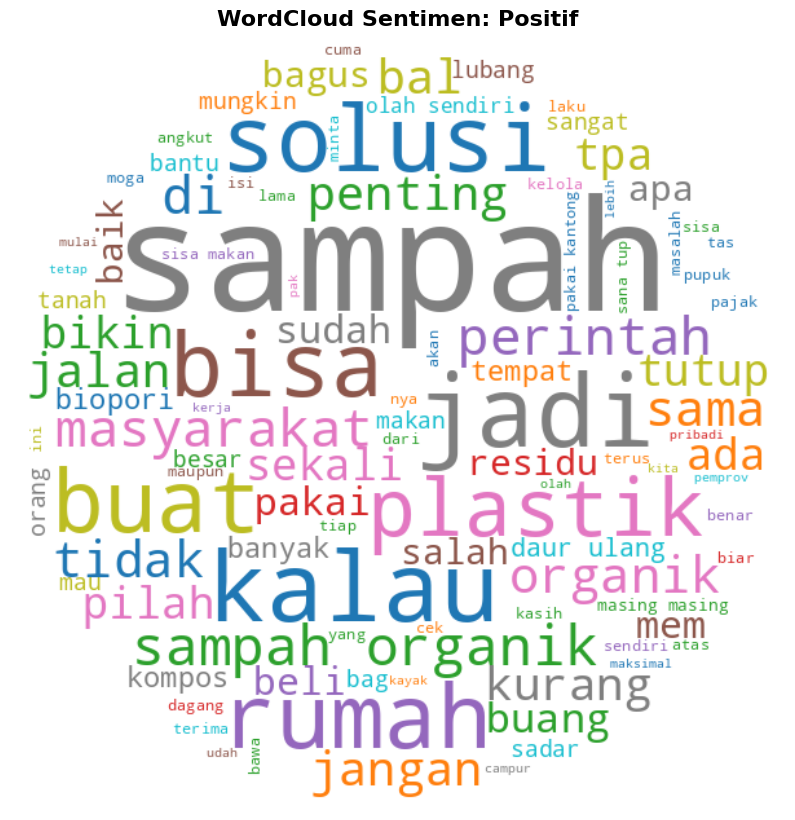

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_circle_mask(diameter=600):
    """Membuat mask berbentuk lingkaran dengan ukuran diameter tertentu."""
    x, y = np.ogrid[:diameter, :diameter]
    center = diameter // 2
    radius = diameter // 2
    mask = (x - center)**2 + (y - center)**2 > radius**2
    mask = 255 * mask.astype(int)
    return mask

def generate_wordcloud(text, title):
    circle_mask = create_circle_mask(600)

    wordcloud = WordCloud(
        width=200, height=200,
        background_color='white',
        colormap='tab10',
        max_words=100,
        prefer_horizontal=0.9,
        min_font_size=10,
        max_font_size=120,
        random_state=42,
        mask=circle_mask
    ).generate(text)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout(pad=0)
    plt.show()

# WordCloud semua komentar (umum)
all_text = ' '.join(df['text'])
generate_wordcloud(all_text, "WordCloud Umum – Semua Komentar")

# WordCloud per sentimen (positif, negatif, netral)
for label in df['sentimen'].unique():
    sentimen_text = ' '.join(df[df['sentimen'] == label]['text'])
    generate_wordcloud(sentimen_text, f"WordCloud Sentimen: {label.capitalize()}")

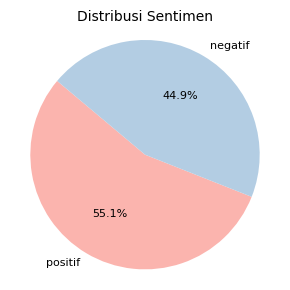

In [ ]:
sentimen_count = Counter(y_test_pred)

labels = list(sentimen_count.keys())
jumlah = list(sentimen_count.values())
colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(3, 3))
plt.pie(
    jumlah,
    labels=labels,
    colors=plt.cm.Pastel1.colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    radius=0.8
)
plt.title("Distribusi Sentimen", fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
!pip install gensim
from gensim import corpora
dictionary = corpora.Dictionary(tokenized)

print("\nContoh 10 kata dalam dictionary:")
for i in range(10):
    print(f"{i}: {dictionary[i]}")

corpus = [dictionary.doc2bow(text) for text in tokenized]

print("\nContoh representasi BoW (komentar pertama):")
print(corpus[0])
print("\nArtinya:")
for id, freq in corpus[0]:
    print(f"Kata: {dictionary[id]} | Frekuensi: {freq}")


Contoh 10 kata dalam dictionary:
0: gaberner
1: mau
2: nya
3: nyontoh
4: surabaya
5: banjir
6: biar
7: buang
8: disungai
9: hahahaha

Contoh representasi BoW (komentar pertama):
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

Artinya:
Kata: gaberner | Frekuensi: 1
Kata: mau | Frekuensi: 1
Kata: nya | Frekuensi: 1
Kata: nyontoh | Frekuensi: 1
Kata: surabaya | Frekuensi: 1


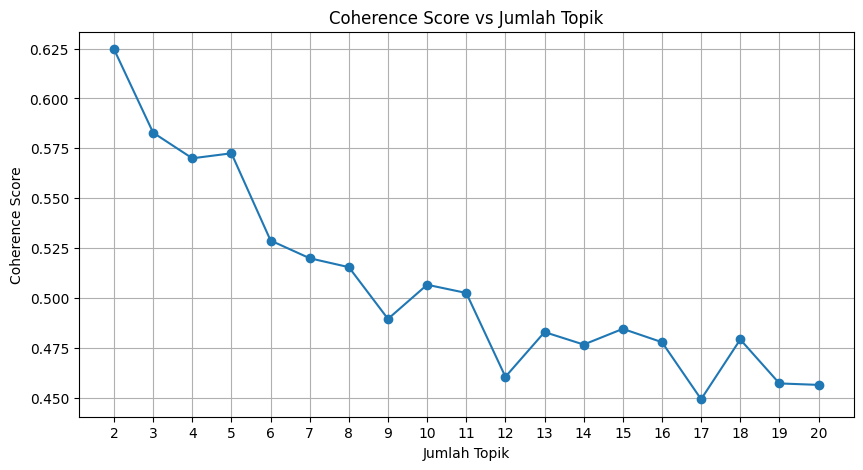

In [ ]:
from gensim.models import LdaModel

from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, start=2, limit=20, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=20,
                                                        step=1)

x = range(2, 21, 1)
plt.figure(figsize=(10,5))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Jumlah Topik")
plt.xticks(x)
plt.grid(True)
plt.show()

In [ ]:
best_num_topics = 2
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=best_num_topics,
                     random_state=42,
                     passes=10,
                     per_word_topics=True)

for idx, topic in lda_model.print_topics(num_words=10):
    print(f"\nTopik {idx + 1}:")
    print(topic)

coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=tokenized,
                                     dictionary=dictionary,
                                     coherence='c_v')

coherence_score = coherence_model_lda.get_coherence()
for num_topics, score in zip(range(2, 21), coherence_values):
    print(f"Jumlah Topik = {num_topics:>2} | Coherence Score = {score:.4f}")


Topik 1:
0.042*"sampah" + 0.018*"solusi" + 0.013*"buang" + 0.011*"organik" + 0.009*"kalau" + 0.008*"pemerintah" + 0.007*"buat" + 0.007*"masyarakat" + 0.007*"pak" + 0.007*"apa"

Topik 2:
0.029*"sampah" + 0.013*"bali" + 0.008*"nya" + 0.006*"banyak" + 0.006*"tidak" + 0.006*"tpa" + 0.006*"uang" + 0.005*"jangan" + 0.005*"pak" + 0.005*"kalau"
Jumlah Topik =  2 | Coherence Score = 0.6247
Jumlah Topik =  3 | Coherence Score = 0.5828
Jumlah Topik =  4 | Coherence Score = 0.5700
Jumlah Topik =  5 | Coherence Score = 0.5725
Jumlah Topik =  6 | Coherence Score = 0.5288
Jumlah Topik =  7 | Coherence Score = 0.5199
Jumlah Topik =  8 | Coherence Score = 0.5155
Jumlah Topik =  9 | Coherence Score = 0.4895
Jumlah Topik = 10 | Coherence Score = 0.5066
Jumlah Topik = 11 | Coherence Score = 0.5025
Jumlah Topik = 12 | Coherence Score = 0.4605
Jumlah Topik = 13 | Coherence Score = 0.4829
Jumlah Topik = 14 | Coherence Score = 0.4767
Jumlah Topik = 15 | Coherence Score = 0.4845
Jumlah Topik = 16 | Coherence 

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.7 MB/s eta 0:00:00


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.071536  0.0       1        1  58.499069
1     -0.071536  0.0       2        1  41.500931, topic_info=           Term       Freq      Total Category  logprob  loglift
74       solusi  95.000000  95.000000  Default  30.0000  30.0000
7         buang  64.000000  64.000000  Default  29.0000  29.0000
78         bali  61.000000  61.000000  Default  28.0000  28.0000
96      organik  58.000000  58.000000  Default  27.0000  27.0000
158        uang  23.000000  23.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
171       pakai   9.143160  15.901520   Topic2  -5.9346   0.3260
173       punya  10.144653  30.122444   Topic2  -5.8306  -0.2089
77          apa  10.633643  42.797872   Topic2  -5.7835  -0.5130
55           di  10.364484  41.231471   Topic2  -5.8092  -0.5014
64   masyarakat  10.323560  44.414418   Topic2  -5.8131  -0.5797

[158 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76        1  0.648402        ada
76        2  0.347358        ada
77        1  0.747701        apa
77        2  0.257022        apa
331       2  0.969324      asing
...     ...       ...        ...
2007      1  0.096727         wi
2007      2  0.870539         wi
347       2  0.969767  wisatawan
193       1  0.834107       yang
193       2  0.147195       yang

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [ ]:
def preprocess_input(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()

    for key, value in norm.items():
        text = text.replace(key, value)

    text = stop_remover.remove(text)
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def predict_sentiment(text):
    cleaned_text = preprocess_input(text)
    tfidf_vector = vectorizer.transform([cleaned_text])
    prediction = nb_model.predict(tfidf_vector)
    prediction_label = prediction[0]
    return prediction_label

In [ ]:
input_text = "dasar pemerintah egois"
hasil_sentimen = predict_sentiment(input_text)

print("Teks:", input_text)
print("Prediksi Sentimen:", hasil_sentimen)

Teks: dasar pemerintah egois
Prediksi Sentimen: negatif
